In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import math
import random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import gym

In [2]:
class ExpectedSarsaAgent:
    def __init__(self, coder, num_actions, alpha, gamma, epsilon):
        self.coder = coder
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.weights = np.random.uniform(-0.001, 0.001, (self.coder.num_ind, num_actions))

    def select_action(self, state):
        encoded_state = self.coder.encode(state)
        q_values = np.dot(encoded_state, self.weights)
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            return np.argmax(q_values)

    def update(self, state, action, reward, next_state, done):
        current_encoded_state = self.coder.encode(state)
        next_encoded_state = self.coder.encode(next_state)
        current_q = np.dot(current_encoded_state, self.weights[:, action])

        next_q_values = np.dot(next_encoded_state, self.weights)
        expected_next_q = np.sum(next_q_values * self.get_action_probabilities(next_q_values)) if not done else 0

        td_error = reward + self.gamma * expected_next_q - current_q
        self.weights[:, action] += self.alpha * td_error * current_encoded_state

    def get_action_probabilities(self, q_values):
        action_probabilities = np.ones(self.num_actions) * self.epsilon / self.num_actions
        best_action = np.argmax(q_values)
        action_probabilities[best_action] += (1.0 - self.epsilon)
        return action_probabilities

In [3]:
class RBFDiscritizer:
    def __init__(self, num_rbf_per_state, state_bounds, num_states):
        self.num_rbf_per_state = num_rbf_per_state
        self.state_bounds = state_bounds
        self.num_states = num_states
        self.num_rbf = num_rbf_per_state * np.ones(self.num_states).astype(int)
        self.num_ind = np.prod(self.num_rbf)
        self.width = 1. / (self.num_rbf - 1.)
        self.rbf_sigma = self.width[0] / 2.
        self.rbf_den = 2 * self.rbf_sigma ** 2
        self.centres = self.build_centers()

    def build_centers(self):
        # Generate a meshgrid for the centers based on the number of RBFs per dimension
        ranges = [np.linspace(0, 1, num) for num in self.num_rbf]
        mesh = np.meshgrid(*ranges, indexing='ij')
        # Flatten the meshgrid and stack it to get the center coordinates
        center_coords = np.stack([axis.flatten() for axis in mesh], axis=-1)
        return center_coords

    def normalize_state(self, state):
        normalized = np.zeros(len(state))
        for i, (lower, upper) in enumerate(self.state_bounds):
            normalized[i] = (state[i] - lower) / (upper - lower)
        return normalized

    def encode(self, state):
        normalized_state = self.normalize_state(state)
        _phi = np.zeros(self.num_ind)
        for _k in range(self.num_ind):
            _phi[_k] = np.exp(-np.linalg.norm(normalized_state - self.centres[_k, :]) ** 2 / self.rbf_den)
        return _phi

In [5]:
def save_rewards_data(rewards_data, filename='rewards_data.pkl'):
    """Save the rewards data to a pickle file."""
    with open(filename, 'wb') as file:
        pickle.dump(rewards_data, file)
    print(f'Rewards data saved to {filename}')

def load_rewards_data(filename='rewards_data.pkl'):
    """Load the rewards data from a pickle file."""
    try:
        with open(filename, 'rb') as file:
            rewards_data = pickle.load(file)
        print(f'Rewards data loaded from {filename}')
        return rewards_data
    except FileNotFoundError:
        print(f'Error: The file {filename} does not exist. Please check the file path and try again.')
        return None
    except Exception as e:
        print(f'An error occurred while loading the data: {e}')
        return None

def run_episode(env, agent):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        # Select the current action
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)

        # Update the Q-value for Q-learning
        agent.update(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

    return total_reward


def train_agent(env, coder, Algorithm, run_episode, save_file, epsilons, alphas, gamma, num_runs=50, num_episodes=1000):
    # Initialize storage for reward data
    rewards_data = {epsilon: {alpha: [] for alpha in alphas} for epsilon in epsilons}

    # Loop over epsilon and alpha combinations
    for epsilon in epsilons:
        for alpha in alphas:
            print(f"Training with epsilon: {epsilon}, alpha: {alpha}")
            run_rewards = []  # Collect rewards for each run for the current config

            for run in range(num_runs):
                print(f"Run {run + 1}/{num_runs}")
                # Initialize the agent with current epsilon and alpha
                agent = Algorithm(alpha=alpha, epsilon=epsilon, num_actions=env.action_space.n, coder=coder, gamma=gamma)

                episode_rewards = []  # Collect rewards for each episode in the current run
                for episode in range(num_episodes):
                    reward = run_episode(env, agent)
                    episode_rewards.append(reward)

                    # if (episode + 1) % 100 == 0:
                    print(f'Episode {episode + 1}: total reward = {reward}')

                run_rewards.append(episode_rewards)

            # Store the rewards for the current epsilon and alpha configuration
            rewards_data[epsilon][alpha] = run_rewards
            print(f"Finished training with epsilon: {epsilon}, alpha: {alpha}")

    if not(save_file == ""):
        save_rewards_data(rewards_data, save_file)

    return rewards_data

In [11]:
env = gym.make('CartPole-v1')

num_states = 4
num_rbf_per_state=4
state_bounds = [(-2.4, 2.4), (-10.0, 10.0), (-0.42, 0.42), (-10.0, 10.0)]

discretizer = RBFDiscritizer(num_rbf_per_state=num_rbf_per_state, state_bounds=state_bounds, num_states=num_states)

rewards = train_agent(
    env=env,
    coder=discretizer,
    Algorithm=ExpectedSarsaAgent,
    run_episode=run_episode,
    save_file="Expected_SARSA_RBF_CartPole",
    epsilons=[0.1],
    alphas=[0.05, 0.1, 0.2],
    gamma=0.99,
    num_runs=30,
    num_episodes=1000
)

Training with epsilon: 0.1, alpha: 0.05
Run 1/30
Episode 1: total reward = 10.0
Episode 2: total reward = 9.0
Episode 3: total reward = 9.0
Episode 4: total reward = 9.0
Episode 5: total reward = 12.0
Episode 6: total reward = 9.0
Episode 7: total reward = 11.0
Episode 8: total reward = 9.0
Episode 9: total reward = 9.0
Episode 10: total reward = 10.0
Episode 11: total reward = 11.0
Episode 12: total reward = 10.0
Episode 13: total reward = 9.0
Episode 14: total reward = 10.0
Episode 15: total reward = 9.0
Episode 16: total reward = 10.0
Episode 17: total reward = 10.0
Episode 18: total reward = 10.0
Episode 19: total reward = 10.0
Episode 20: total reward = 10.0
Episode 21: total reward = 8.0
Episode 22: total reward = 9.0
Episode 23: total reward = 9.0
Episode 24: total reward = 9.0
Episode 25: total reward = 11.0
Episode 26: total reward = 10.0
Episode 27: total reward = 9.0
Episode 28: total reward = 13.0
Episode 29: total reward = 10.0
Episode 30: total reward = 10.0
Episode 31: t

In [14]:
def plot_rewards(rewards_data, algorithm_name="Expected SARSA"):
    """Plot the average performance and IQR of the policy."""
    plt.figure(figsize=(14, 7))

    for epsilon, alphas in rewards_data.items():
        for alpha, data in alphas.items():
            # Calculate average and IQR across runs for each episode
            data = np.array(data)  # Convert to numpy array for easier slicing
            avg_rewards = np.mean(data, axis=0)
            lower_quartile = np.percentile(data, 25, axis=0)
            upper_quartile = np.percentile(data, 75, axis=0)

            episodes = np.arange(len(avg_rewards)) + 1
            plt.plot(episodes, avg_rewards, label=f'ε={epsilon}, α={alpha}')
            plt.fill_between(episodes, lower_quartile, upper_quartile, alpha=0.25)

    plt.title(f'Average Performance and IQR by Epsilon and Alpha ({algorithm_name})')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.show()

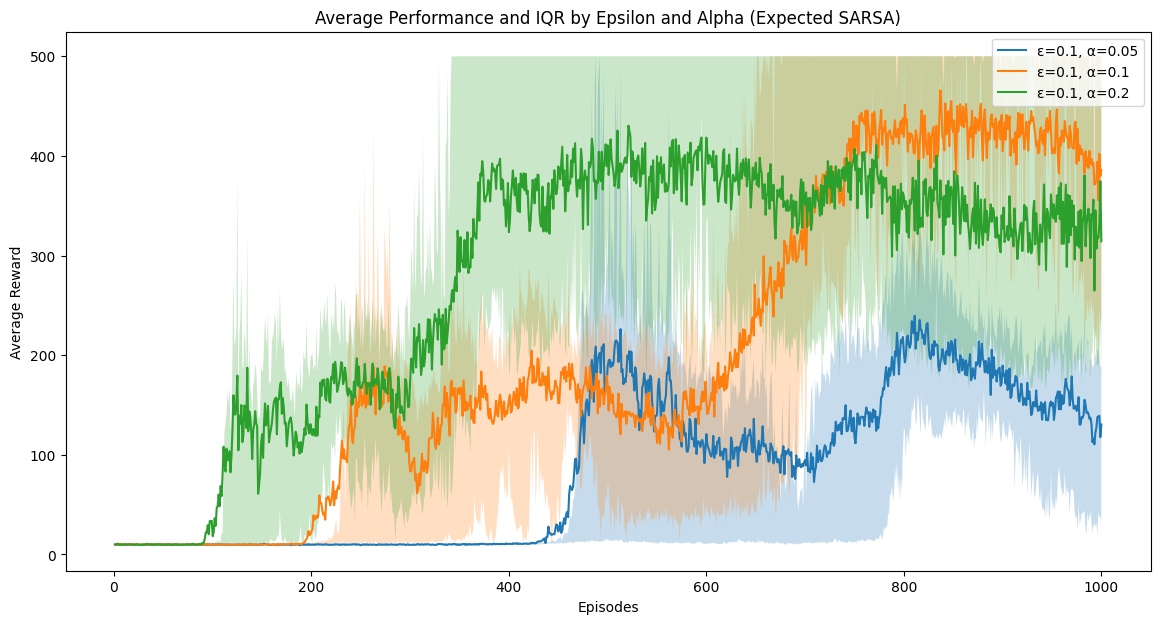

In [15]:
plot_rewards(rewards)

In [16]:
data = load_rewards_data("Expected_SARSA_RBF_CartPole")

Rewards data loaded from Expected_SARSA_RBF_CartPole


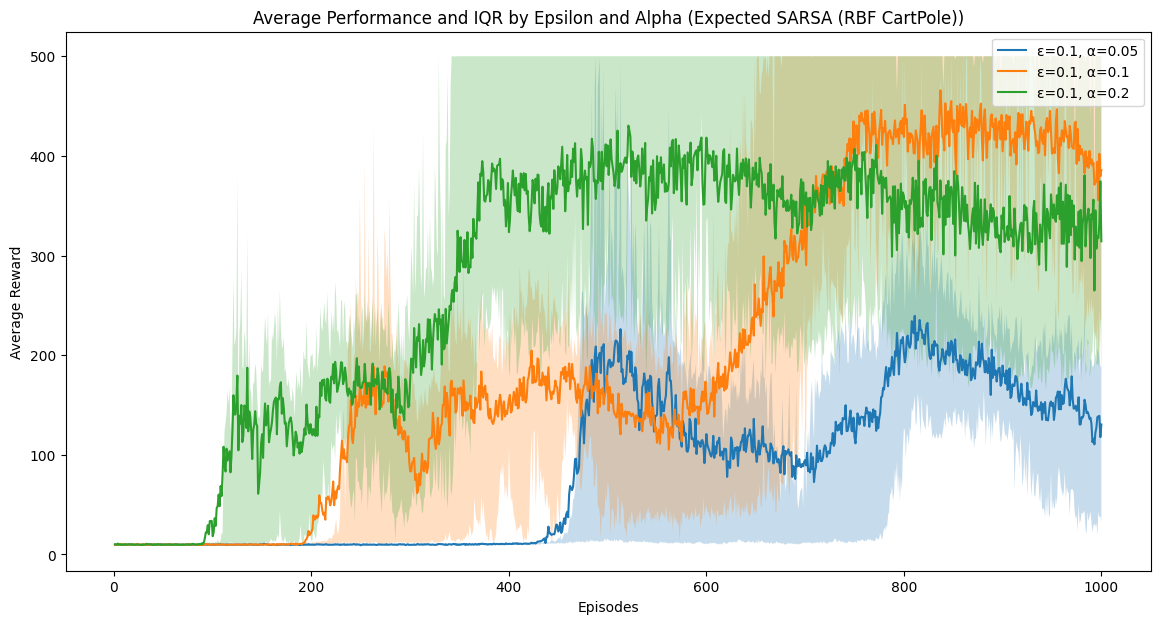

In [17]:
plot_rewards(rewards, algorithm_name="Expected SARSA (RBF CartPole)")